In [57]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [67]:
sns.set()

In [3]:
import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data

raw_data = pd.read_csv('RFMdata.csv')
df = raw_data.copy()
#df.drop(df.columns[0],axis=1,inplace=True)
#df.drop_duplicates(inplace=True)
df.info()

C:\Users\27722\AppData\Local\Temp\ipykernel_8468\2111295714.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('RFMdata.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004437 entries, 0 to 1004436
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   InvoiceNo       1004437 non-null  object 
 1   StockCode       1004437 non-null  object 
 2   Description     1004437 non-null  object 
 3   Quantity        1004437 non-null  int64  
 4   Price           1004437 non-null  float64
 5   CustomerID      1004437 non-null  float64
 6   Country         1004437 non-null  object 
 7   Month_Year      1004437 non-null  object 
 8   Total           1004437 non-null  float64
 9   Date            1004437 non-null  object 
 10  recency         1004437 non-null  int64  
 11  frequency       1004437 non-null  int64  
 12  monetary_value  1004437 non-null  float64
 13  Cluster         1004437 non-null  int64  
dtypes: float64(4), int64(4), object(6)
memory usage: 107.3+ MB


In [4]:
#df = df[(df['Quantity'] > 0) & (df['monetary_value'] > 0)]
df.drop(columns=['StockCode','Description','Country'],inplace=True)
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['CustomerID'] = df['CustomerID'].astype(str)
df.describe(include='all')

,InvoiceNo,Quantity,Price,CustomerID,Month_Year,Total,Date,recency,frequency,monetary_value,Cluster
count,1004437.0,1.004437e+06,1.004437e+06,1004437,1004437,1.004437e+06,1004437,1.004437e+06,1.004437e+06,1.004437e+06,1.004437e+06
unique,39754.0,NaN,NaN,8588,25,NaN,36928,NaN,NaN,NaN,NaN
top,573585.0,NaN,NaN,17841.0,2011-11,NaN,2011-10-31 14:41:00,NaN,NaN,NaN,NaN
freq,1113.0,NaN,NaN,12435,81790,NaN,1113,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN,NaN
mean,NaN,1.114842e+01,3.517832e+00,NaN,NaN,1.974415e+01,NaN,1.396452e+02,8.481663e+02,1.659281e+04,1.679281e+00
std,NaN,1.286908e+02,2.750591e+01,NaN,NaN,2.016917e+02,NaN,1.925009e+02,1.960354e+03,5.458827e+04,1.230251e+00
min,NaN,1.000000e+00,1.000000e-03,NaN,NaN,1.000000e-03,NaN,1.000000e+00,1.000000e+00,1.900000e-01,0.000000e+00
25%,NaN,1.000000e+00,1.250000e+00,NaN,NaN,4.130000e+00,NaN,1.000000e+01,1.420000e+02,1.486200e+03,0.000000e+00


In [5]:
df['monetary_value'].min()

0.19

In [6]:
today_date = df['Date'].max()

In [7]:
cltv_df = df.groupby('CustomerID').agg({'Date': [
                                lambda x: (today_date - x.max()).days,
                                lambda x: (today_date - x.min()).days,
                                ],
                                "InvoiceNo": "nunique",
                                'Total': 'sum'})
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency", "T", "frequency", "monetary"]
cltv_df.reset_index(inplace=True)

1. Calculate Average Order Value

In [8]:
cltv_df['avg_order_value']= cltv_df['monetary']/cltv_df['frequency']

cltv_df.sample(15)

,CustomerID,recency,T,frequency,monetary,avg_order_value
924,13276.0,63,641,5,1891.91,378.382000
4641,17033.0,85,396,4,1332.79,333.197500
5920,18326.0,731,731,1,28.75,28.750000
5501,17905.0,70,679,13,2178.87,167.605385
5636,18042.0,53,541,2,281.15,140.575000
5184,17583.0,559,559,1,135.95,135.950000
7465,19871.0,338,338,1,7.62,7.620000
4582,16970.0,625,625,1,71.40,71.400000
3907,16289.0,461,461,1,136.31,136.310000
2121,14488.0,67,67,1,1064.28,1064.280000


In [9]:
total_customers = cltv_df.shape[0]

2. Calculate Purchase Frequency

In [10]:
purchase_frequency = sum(cltv_df['frequency'])/total_customers

3. Calculate Churn Rate

In [11]:
repeaters = cltv_df[cltv_df.frequency>1]
repeat_customers = repeaters.shape[0]
repeat_customers

4433

In [12]:
churn_rate = 1 - (repeat_customers/total_customers)

In [13]:
purchase_frequency,churn_rate

(4.631113181183046, 0.4838146250582208)

### 4. Calculate Profit Margin

we assume a 5% profit margin for this, however this will be business specific

In [14]:
cltv_df['profit_margin'] = cltv_df['monetary']*0.05

## Customer Life Time Value

CLTV = (Avg Order Value * Purchase Frequency / Churn Rate) * Profit Margin

In [15]:
cltv_df['CLTV'] = (cltv_df['avg_order_value']*purchase_frequency/churn_rate)*cltv_df['profit_margin']

cltv_df.sample(15)

,CustomerID,recency,T,frequency,monetary,avg_order_value,profit_margin,CLTV
954,13306.0,429,429,1,53.65,53.650000,2.6825,1.377577e+03
7371,19777.0,364,364,1,208.22,208.220000,10.4110,2.075015e+04
2180,14547.0,3,53,8,3974.75,496.843750,198.7375,9.451616e+05
1234,13594.0,52,485,2,533.32,266.660000,26.6660,6.806473e+04
354,12701.0,79,632,6,2248.41,374.735000,112.4205,4.032517e+05
2808,15181.0,65,730,5,1200.20,240.040000,60.0100,1.378839e+05
934,13286.0,599,599,1,734.91,734.910000,36.7455,2.584906e+05
1017,13372.0,89,89,1,378.64,378.640000,18.9320,6.861663e+04
2535,14905.0,157,735,8,1971.39,246.423750,98.5695,2.325046e+05
4069,16451.0,87,734,3,1013.15,337.716667,50.6575,1.637580e+05


In [16]:
cltv_df[['frequency','monetary']].corr()

,frequency,monetary
frequency,1.000000,0.621592
monetary,0.621592,1.000000


In [17]:
cltv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8588 entries, 0 to 8587
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       8588 non-null   object 
 1   recency          8588 non-null   int64  
 2   T                8588 non-null   int64  
 3   frequency        8588 non-null   int64  
 4   monetary         8588 non-null   float64
 5   avg_order_value  8588 non-null   float64
 6   profit_margin    8588 non-null   float64
 7   CLTV             8588 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 536.9+ KB


In [18]:
cltv_df.head(5)

,CustomerID,recency,T,frequency,monetary,avg_order_value,profit_margin,CLTV
0,12346.0,325,725,12,77556.46,6463.038333,3877.8230,2.399005e+08
1,12347.0,1,403,8,4921.53,615.191250,246.0765,1.449061e+06
2,12348.0,74,437,5,1658.40,331.680000,82.9200,2.632601e+05
3,12349.0,18,588,3,3678.69,1226.230000,183.9345,2.158945e+06
4,12350.0,309,309,1,294.40,294.400000,14.7200,4.148127e+04


In [26]:
cltv_df.describe()

,recency,T,frequency,monetary,avg_order_value,profit_margin,CLTV
count,8588.000000,8588.000000,8588.000000,8588.000000,8588.000000,8588.000000,8.588000e+03
mean,257.953190,444.913251,4.631113,2309.240052,555.813102,115.462003,2.939781e+06
std,226.138513,223.152499,10.980335,12027.424063,1715.079180,601.371203,8.003767e+07
min,0.000000,0.000000,1.000000,0.190000,0.190000,0.009500,1.727761e-02
25%,42.000000,268.000000,1.000000,198.627500,135.950000,9.931375,1.494467e+04
50%,206.000000,473.000000,2.000000,688.625000,268.275000,34.431250,9.394268e+04
75%,432.000000,643.000000,5.000000,1816.007500,468.741250,90.800375,4.800465e+05
max,738.000000,738.000000,397.000000,580987.040000,84236.250000,29049.352000,6.792106e+09


In [28]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [30]:
cltv_df

,CustomerID,recency,T,frequency,monetary,avg_order_value,profit_margin,CLTV
0,12346.0,325,725,12,77556.46,6463.038333,3877.8230,2.399005e+08
1,12347.0,1,403,8,4921.53,615.191250,246.0765,1.449061e+06
2,12348.0,74,437,5,1658.40,331.680000,82.9200,2.632601e+05
3,12349.0,18,588,3,3678.69,1226.230000,183.9345,2.158945e+06
6,12352.0,35,392,10,2569.84,256.984000,128.4920,3.160739e+05
...,...,...,...,...,...,...,...,...
8155,20561.0,141,141,3,1244.03,414.676667,62.2015,2.468976e+05
8166,20572.0,137,137,2,269.09,134.545000,13.4545,1.732772e+04
8180,20586.0,134,134,2,1487.68,743.840000,74.3840,5.296213e+05
8365,20771.0,59,59,2,52.90,26.450000,2.6450,6.696652e+02


In [37]:
data = summary_data_from_transaction_data(
    df, 
    customer_id_col='CustomerID', 
    datetime_col='Date', 
    monetary_value_col='monetary_value',
    observation_period_end=pd.to_datetime(today_date))  # Replace 'current_date' with the actual current date

# Display the prepared data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8588 entries, 12346.0 to 20993.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       8588 non-null   float64
 1   recency         8588 non-null   float64
 2   T               8588 non-null   float64
 3   monetary_value  8588 non-null   float64
dtypes: float64(4)
memory usage: 335.5+ KB
None


In [38]:
data

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,7.0,400.0,725.0,343464.322857
12347.0,7.0,402.0,404.0,127959.780000
12348.0,4.0,363.0,438.0,11194.200000
12349.0,2.0,571.0,589.0,231757.470000
12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...
20989.0,0.0,0.0,1.0,0.000000
20990.0,0.0,0.0,1.0,0.000000
20991.0,0.0,0.0,0.0,0.000000


In [39]:
#Recency & Tenure
data["recency"] = data["recency"] / 7
data["T"] = data["T"] / 7

#Frequency
data = data[(data['frequency'] > 1)]

In [40]:
BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting

BGF.fit(data["frequency"], data["recency"], data["T"])

<lifetimes.BetaGeoFitter: fitted with 3178 subjects, a: 0.08, alpha: 15.26, b: 2.57, r: 1.76>

In [41]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    1, data["frequency"], data["recency"], data["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,CustomerID,Expected Number of Transactions
0,14911.0,2.117546
1,12748.0,1.684761
2,15311.0,1.629082
3,17841.0,1.605962
4,14606.0,1.483341
5,13089.0,1.100025
6,14156.0,1.006081
7,14527.0,1.000536
8,12971.0,0.839244
9,13798.0,0.832440


In [42]:
BGF.conditional_expected_number_of_purchases_up_to_time(
    4, data["frequency"], data["recency"], data["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,CustomerID,Expected Number of Transactions
0,14911.0,8.461886
1,12748.0,6.732417
2,15311.0,6.509943
3,17841.0,6.417548
4,14606.0,5.927539
5,13089.0,4.395783
6,14156.0,4.020379
7,14527.0,3.998219
8,12971.0,3.353631
9,13798.0,3.326469


In [45]:
from lifetimes.plotting import plot_period_transactions

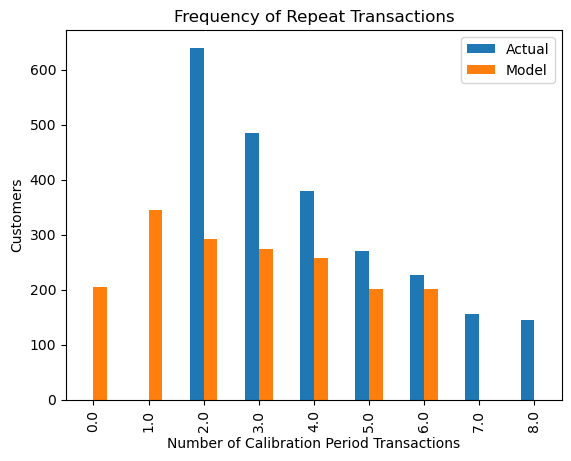

In [46]:
plot_period_transactions(BGF, max_frequency=7)
plt.show()

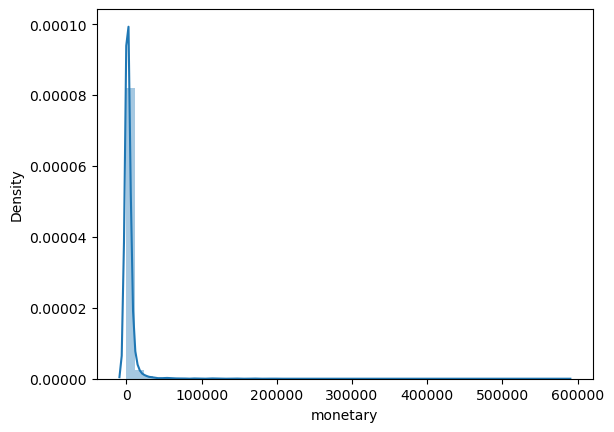

In [58]:
ax = sns.distplot(cltv_df['monetary'])

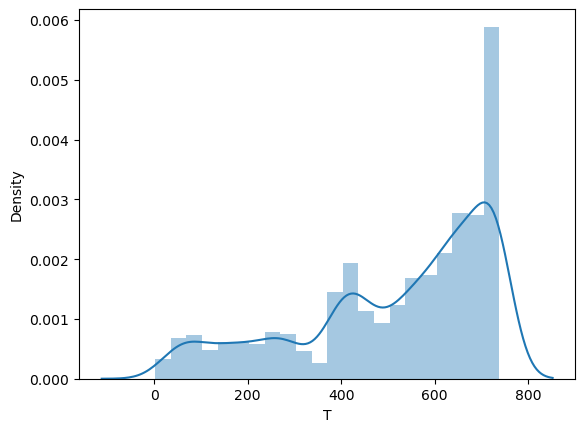

In [59]:
ax = sns.distplot(cltv_df['T'])

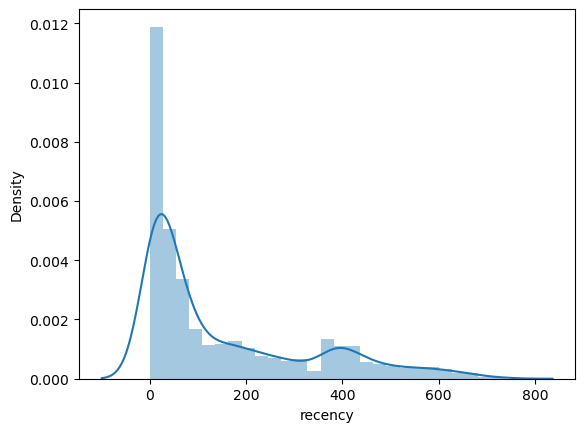

In [60]:
ax = sns.distplot(cltv_df['recency'])

recency: 


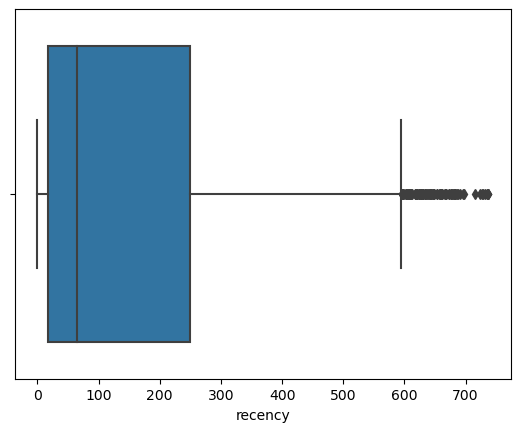

frequency: 


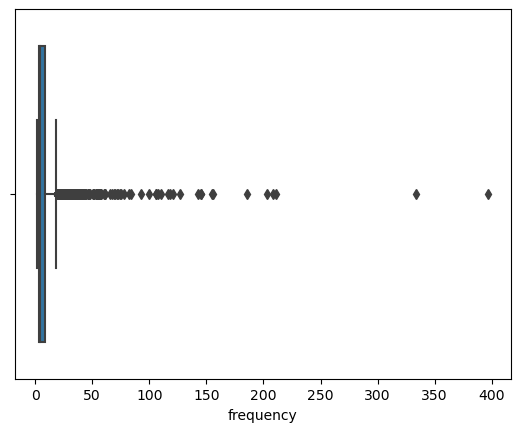

monetary: 


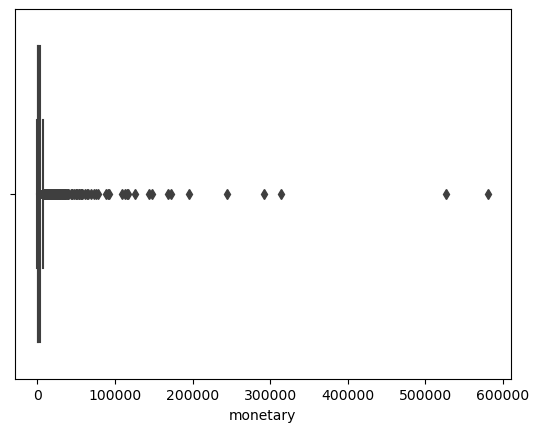

T: 


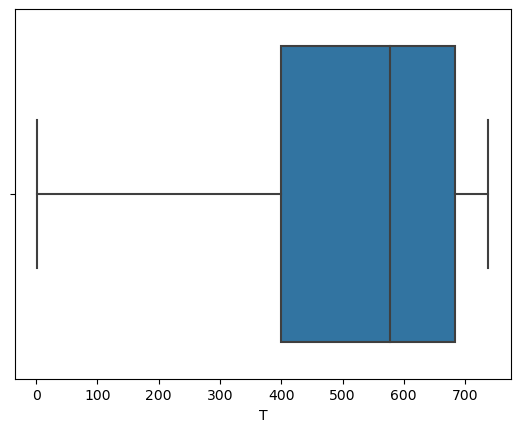

In [61]:
list1 = ['recency','frequency','monetary','T']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=cltv_df[str(i)])
    plt.show()


recency: 


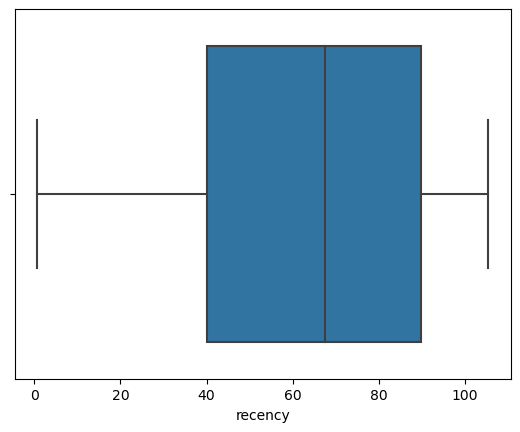

frequency: 


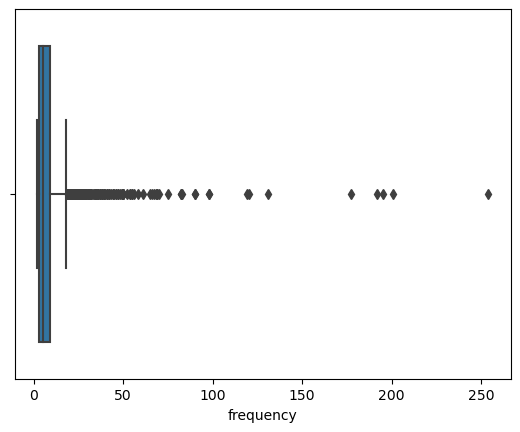

monetary_value: 


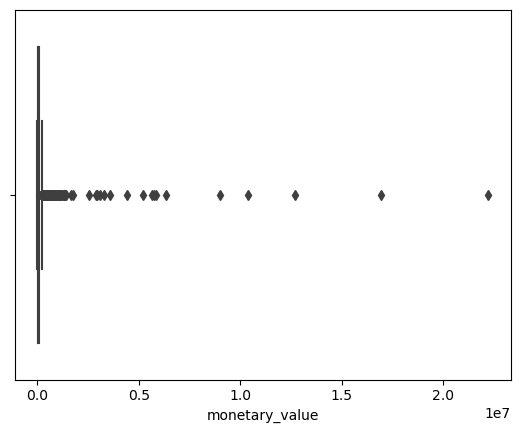

T: 


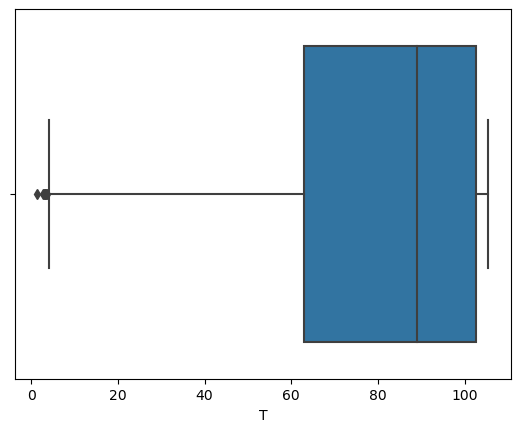

In [62]:
list2 = ['recency','frequency','monetary_value','T']
for i in list2:
    print(str(i)+': ')
    ax = sns.boxplot(x=data[str(i)])
    plt.show()

In [69]:
cltv_df

,CustomerID,recency,T,frequency,monetary,avg_order_value,profit_margin,CLTV
0,12346.0,325,725,12,77556.46,6463.038333,3877.8230,2.399005e+08
1,12347.0,1,403,8,4921.53,615.191250,246.0765,1.449061e+06
2,12348.0,74,437,5,1658.40,331.680000,82.9200,2.632601e+05
3,12349.0,18,588,3,3678.69,1226.230000,183.9345,2.158945e+06
6,12352.0,35,392,10,2569.84,256.984000,128.4920,3.160739e+05
...,...,...,...,...,...,...,...,...
8155,20561.0,141,141,3,1244.03,414.676667,62.2015,2.468976e+05
8166,20572.0,137,137,2,269.09,134.545000,13.4545,1.732772e+04
8180,20586.0,134,134,2,1487.68,743.840000,74.3840,5.296213e+05
8365,20771.0,59,59,2,52.90,26.450000,2.6450,6.696652e+02


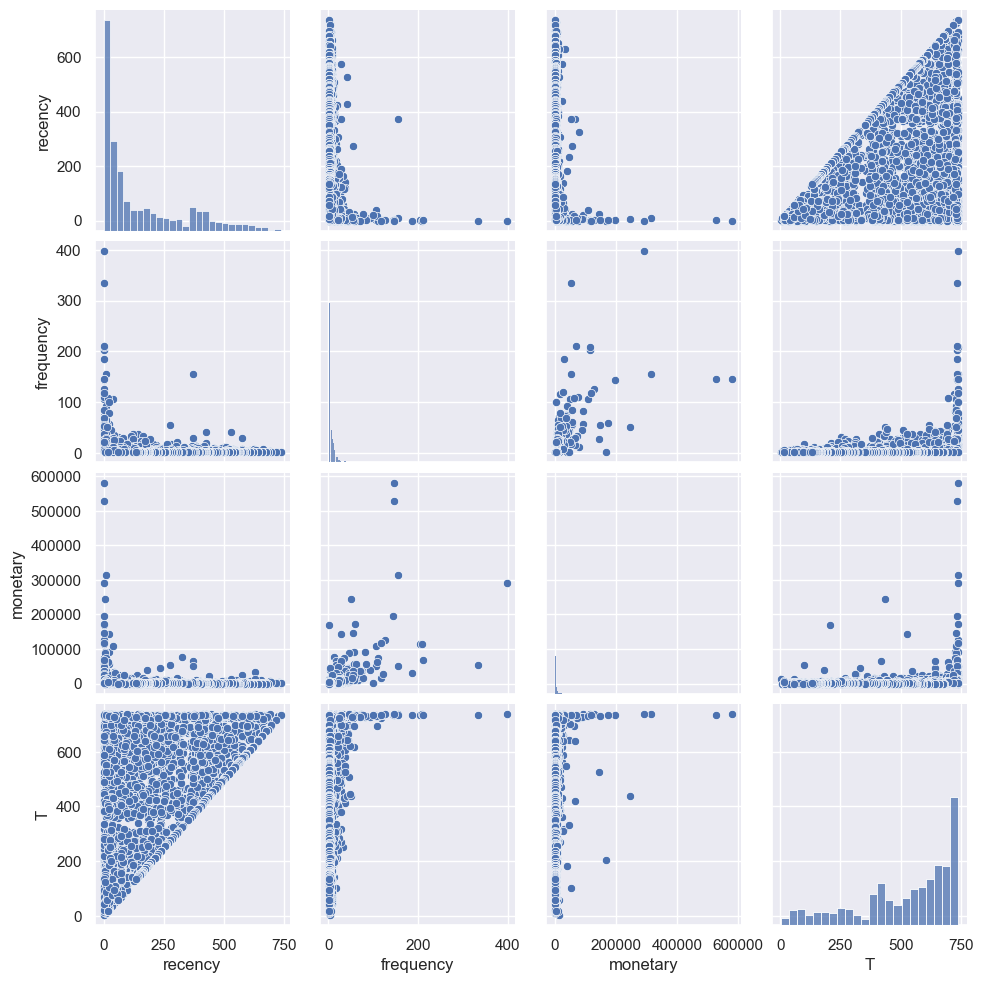

In [68]:
sns.pairplot(data=cltv_df,vars=list1,palette='Set2')